In [1]:
from matplotlib import pyplot as plt
import numpy as np
import contextvars
import torch
plt.style.use("seaborn")
torch.manual_seed(777)
np.random.seed(777)

In [2]:
def expand_dims_as(t1,t2):
    """
    Adds (t2.dim) dimensions to t1 to make it boradcastable with t2. 
    Returns an expanded copy of t1. 
    
    Parameters
    ----------
    t1 : torch.Tensor
        tensor to expand.
    t2 : torch.Tensor
        tensor to expand as.
    """
    result = t1[(...,)+(None,)*t2.dim()]
    return result

def Heaviside(tensor):
    return (tensor>0)

class Context():
    """
    Emulates ctx object from torch.autograd.
    """
    def __init__(self):
        self.fitter = None
        self.residual = None
        self.shape = None

class LegendreFitter():
    def __init__(self,mbins=None,m=None,order=0,power=1):
        """
        Object used to fit an array of using Legendre polynomials.

        Parameters
        ----------
        mbins :int or Array[float] (optional)
            Array of bin edges or number of bins in m used in the fit. The fit is integrated along m.
        m : Array[float] (optional)
            Array of all masses. Has shape (mbins,bincontent)
        order : int, default 0
            The highest order of legendre polynomial used in the fit.
        power : int, default 1
            Power used in the norm of the difference between the input and the fit. |fit(input) - input|**power
        """
        if m is None:
            if mbins is None:
                raise ValueError("Provide either m or mbins.")
            mbins = torch.linspace(-1,1,mbins+1) # mass bin edges
            m  = (mbins[1:] + mbins[:-1])*0.5    # mass bin centers
            dm = mbins[1:] - mbins[:-1]          # mass bin widths
        else:
            if type(m) != torch.Tensor:
                m = torch.DoubleTensor(m)
            dm = m.max(axis=1)[0] - m.min(axis=1)[0]  # bin widths for each of the mbins.
            m  = m.mean(axis=1) # bin centers
        self.m = m.view(-1)
        self.dm = dm.view(-1)
        self.mbins = self.m.shape[0]
        self.power = power
        self.order = order

    def __call__(self,F):
        """
        Fit F with Legendre polynomials and return the fit.

        Parameters
        ----------
        F : torch.Tensor
            Tensor of CDFs F_m(s) has shape (N,mbins) where N is the number of scores 
        """
        a0 = 1/2 * (F*self.dm).sum(axis=-1).view(-1,1) #integrate over mbins
        fit = a0.expand_as(F) # make boradcastable
        if self.order>0:
            a1 = 3/2 * (F*self.m*self.dm).sum(axis=-1).view(-1,1)
            fit = fit + a1*self.m
        if self.order>1:
            p2 = (self.m**2-1)*0.5
            a2 = 5/2 * (F*p2*self.dm).sum(axis=-1).view(-1,1)
            fit = fit+ a2*p2
        return fit

class LegendreIntegral(): #Defined with a context variable to keep the general skeleton of a PyTorch Function.
    def __init__(self):
        self.ctx = Context() 
    @staticmethod
    def forward(ctx, input, fitter,sbins=None):
        """
        Calculate the Flat loss of input integral{Norm(F(s)-F_flat(s))} integrating over sbins.

        Parameters
        ----------
        input : torch.Tensor
            Scores with shape (mbins,bincontent) where mbins * bincontent = N (or the batch size.)
        fitter : LegendreFitter
            Fitter object used to calculate F_flat(s)
        sbins : int
            Number of s bins to use in the integral.
        """
        s_edges = torch.linspace(0,1,sbins+1,dtype=torch.double) #create s edges to integrate over
        s = (s_edges[1:] + s_edges[:-1])*0.5
        s = expand_dims_as(s,input)
        ds = s_edges[1:] - s_edges[:-1]

        F = Heaviside(s-input).sum(axis=-1).double()/input.shape[-1] # get CDF at s from input values
        integral = ds.matmul((F-fitter(F))**fitter.power).sum(axis=0)/input.shape[0]
        F_state.set(F) # save for plotting
        s_state.set(s)
        F_s_i =  expand_dims_as(input.view(-1),input) #make a flat copy of input and add dimensions for boradcasting
        F_s_i =  Heaviside(F_s_i-input).sum(axis=-1).double()/input.shape[-1] #sum over bin content to get CDF
        residual = F_s_i - fitter(F_s_i)
        ctx.fitter = fitter
        ctx.residual = residual
        ctx.shape = input.shape
        return integral
    
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        shape = ctx.shape
        power = ctx.fitter.power
        dm = ctx.fitter.dm
        m = ctx.fitter.m
        if True: #ctx.needs_input_grad[0]:
            #first_term is the first term in gradient
            #select F_m for m = m_i for each score s_i
            #i.e. keep only Fm(s_i) in the correct mass bin
            first_term = ctx.residual.T # (N,mbins)-> (mbins,N)
            first_term = first_term.reshape(-1,shape[1]) # (mbins,N)-> (mbins**2,bincontent)
            first_term = first_term[(shape[0]+1)*np.arange(shape[0])] #keep rows: 0, mbin+1, 2mbin+2, etc
            first_term = first_term.view(shape) # flatten to (mbins*bincontent=N)
            second_term = ctx.residual.sum(axis=-1)
            second_term = second_term.view(shape) * dm.view(-1,1) * 0.5
            grad_input = grad_output  \
             * (-power)*(first_term-second_term)/np.prod(shape)

        return grad_input, None, None, None


#### Example to show how the first term is calculated
In this example we have 5 mbins and each bin contains 2 data points. a is our F_m(s_i) which has shape (N,mbins).
Summing with delta(m-m_i) means we only want entries where s_i is in the correct bin. For example the first two points are in the 0th bin so the first two rows (0 and 1) must return the entries from the 0th column ie 0 and 5. The next two data points are in the 1st mbin and so rows 2 and 3 must return the entries from the 1st column (11 and 16.)

In [3]:
a = np.arange(50).reshape(10,5)
print(a)
a.T.reshape(-1,2)[(5+1)*np.arange(5)].reshape(5,2)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]
 [30 31 32 33 34]
 [35 36 37 38 39]
 [40 41 42 43 44]
 [45 46 47 48 49]]


array([[ 0,  5],
       [11, 16],
       [22, 27],
       [33, 38],
       [44, 49]])

In [4]:
F_state = contextvars.ContextVar('F_state')
s_state = contextvars.ContextVar('s_state')

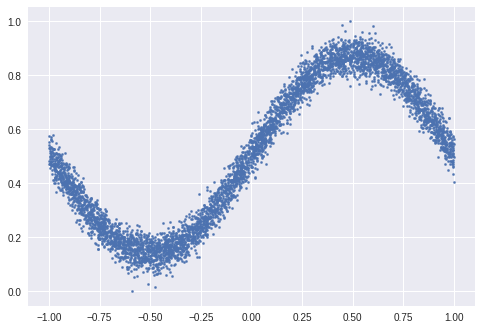

In [5]:
mbins = 500   # number of mass bins
bincontent = 10  # number of points in a given bin
shape=(mbins,bincontent) 
m = np.random.uniform(-1,1,size=np.prod(shape)) #prod(shape)=N=batch_size
m.sort()
m = m.reshape(shape)
scores = np.sin(m*np.pi) + np.random.normal(0,0.1,size=shape)
scores = (scores - scores.min())/(scores.max() - scores.min())
plt.scatter(m,scores,s=5)

In [6]:
scoresTensor = torch.DoubleTensor(scores)
fitter = LegendreFitter(m=m,power=2,order=0)
#fitter = LegendreFitter(mbins=mbins,power=2,order=0)
LI = LegendreIntegral()
LI.forward(LI.ctx,scoresTensor,fitter,sbins=200)
F = F_state.get() #Get CDFs, F(s), to plot them
s = s_state.get() #Get scores s, used to calculate F(s)

## Plotting F_m(s) and its fit using Legendre Polynomials 

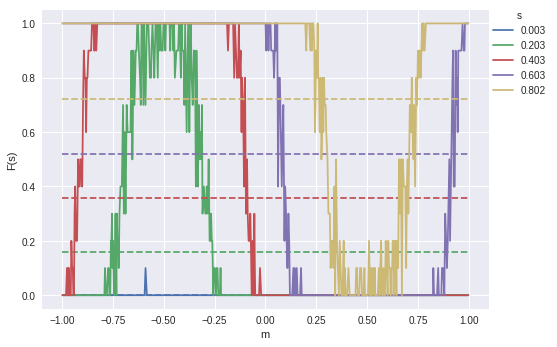

In [7]:
#plotting F(s) and its fit for every 40th score
for i,(Fs, s_value,fit) in enumerate(zip(F[::40],s[::40],fitter(F)[::40])):
    plt.plot(m.mean(axis=1),Fs,c=f"C{i}",label="{:.3f}".format(s_value.item()))
    plt.plot(m.mean(axis=1),fit,c=f"C{i}",ls='--')
plt.legend(title="s",loc=(1,.7))
plt.xlabel('m')
plt.ylabel('F(s)')
plt.show()

#### Effect of different number of sbins on the integral

In [8]:
print("sbins result")
for sbins in [10,50,100,500,1000,5000,1e5,2e5,3e5]:
    result = LI.forward(LI.ctx,scoresTensor,fitter,sbins=int(sbins))
    print("{:<4} {:5.5f}".format(sbins, result))

sbins result
10   0.13429
50   0.13504
100  0.13509
500  0.13509
1000 0.13508
5000 0.13508
100000.0 0.13508
200000.0 0.13508
300000.0 0.13508


In [9]:
grads = LI.backward(LI.ctx,1)[0]

#### print analytical gradients  for the 10 points inside the 0th mass bin

In [10]:
print(*["{:<.4e}".format(number) for number in grads[0]],sep=", ")

1.4853e-04, 7.1849e-05, -1.3464e-04, -1.0335e-04, -6.7794e-05, 8.8209e-06, -3.0940e-05, 1.0958e-04, 1.8845e-04, 4.2471e-05


####  Calculate gradients numerically for the 10 points inside the 0th mass bin

In [14]:
eps = 1e-3
grads_num = list()
for i in range(bincontent):
    scores_epsP = scores.copy()
    scores_epsN = scores.copy()
    scores_epsP[0,i] = scores_epsP[0,i] + eps/2
    scores_epsN[0,i] = scores_epsN[0,i] - eps/2
    scoresTensor_epsP = torch.DoubleTensor(scores_epsP)
    scoresTensor_epsN = torch.DoubleTensor(scores_epsN)
    I_epsP = LI.forward(LI.ctx,scoresTensor_epsP,fitter,sbins=6000).item()
    I_epsN = LI.forward(LI.ctx,scoresTensor_epsN,fitter,sbins=6000).item()
    grads_num.append((I_epsP-I_epsN)/eps)
print(*["{:<.4e}".format(number) for number in grads_num],sep=", ")

1.4845e-04, 5.1996e-05, -1.5465e-04, -1.2329e-04, -8.7741e-05, -1.1139e-05, -5.0886e-05, 8.9583e-05, 1.4845e-04, 2.2471e-05


In [15]:
(np.array(grads[0]) -np.array(grads_num))

array([8.10204510e-08, 1.98527437e-05, 2.00132576e-05, 1.99340544e-05,
       1.99469751e-05, 1.99601018e-05, 1.99464349e-05, 2.00006293e-05,
       4.00012241e-05, 1.99999172e-05])